In [252]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import time
import random
import itertools
import  matplotlib.pyplot as plt
import shapely
from shapely.geometry import LineString, Point
from statistics import mean

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import OneClassSVM
from sklearn.ensemble import RandomForestClassifier

from behalearn.preprocessing import columns
from behalearn.authentication import authentication_metrics
from behalearn.authentication import authentication_results
from behalearn.estimators import VotingClassifier
from behalearn.features import FeatureExtractor
from behalearn.features import temporal
from behalearn.metrics import fmr_score
from behalearn.metrics import fnmr_score
from behalearn.metrics import eer_score
from behalearn.metrics import hter_score
from behalearn.preprocessing import StartEndSegmentSplitter
from behalearn.preprocessing import SegmentSplitter
from behalearn.preprocessing.segment import criteria
from behalearn.visualization import initialize_notebook_output
from behalearn.visualization import label_touches
from behalearn.visualization import plot_fmr_fnmr
from behalearn.visualization import visualize_mobile_data
from behalearn.visualization import visualize_mouse_data
from behalearn.visualization import visualize_custom_data


In [251]:
segment_column = 'segment'
user_column = 'user'
user_name_column = 'username'
compute_features_for_segment = True
delete_nan_features = False
use_selected_features = False

path_to_raw_data = '../login_datasets/2019-01-08_FIIT_-2-poschodie_po_skuske_KPAIS_correct_patterns_only/'
path_to_featutes = "../login_features/" + ("segments" if compute_features_for_segment else "paterns") + ("" if delete_nan_features else "_nan") + "/"

columns_to_identificate_features = ['id', 'pattern_id','device','scenario', user_name_column, user_column]
if compute_features_for_segment:
    columns_to_identificate_features.append(segment_column)
    
train_y_columns = user_name_column

selected_features_dict = {'0': ['duration', 'length', 'start_x', 'start_y', 'velocity_x_mean', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_abs_min', 'velocity_x_abs_max', 'velocity_x_median', 'velocity_x_lower_q', 'velocity_x_upper_q', 'velocity_x_iqr', 'velocity_y_mean', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_min', 'velocity_y_abs_max', 'velocity_y_median', 'velocity_y_lower_q', 'velocity_y_upper_q', 'velocity_y_iqr', 'velocity_x_y_mean', 'velocity_x_y_std', 'velocity_x_y_min', 'velocity_x_y_max', 'velocity_x_y_abs_min', 'velocity_x_y_abs_max', 'velocity_x_y_median', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'velocity_x_y_iqr', 'acceleration_x_mean', 'acceleration_x_std', 'acceleration_x_min', 'acceleration_x_max', 'acceleration_x_abs_min', 'acceleration_x_abs_max', 'acceleration_x_median', 'acceleration_x_lower_q', 'acceleration_x_upper_q', 'acceleration_x_iqr', 'acceleration_y_mean', 'acceleration_y_std', 'acceleration_y_min', 'acceleration_y_max', 'acceleration_y_abs_min', 'acceleration_y_abs_max', 'acceleration_y_median', 'acceleration_y_lower_q', 'acceleration_y_upper_q', 'acceleration_y_iqr', 'acceleration_x_y_mean', 'acceleration_x_y_std', 'acceleration_x_y_min', 'acceleration_x_y_max', 'acceleration_x_y_abs_min', 'acceleration_x_y_abs_max', 'acceleration_x_y_median', 'acceleration_x_y_lower_q', 'acceleration_x_y_upper_q', 'acceleration_x_y_iqr', 'jerk_x_mean', 'jerk_x_std', 'jerk_x_min', 'jerk_x_max', 'jerk_x_abs_min', 'jerk_x_abs_max', 'jerk_x_median', 'jerk_x_lower_q', 'jerk_x_upper_q', 'jerk_x_iqr', 'jerk_y_mean', 'jerk_y_std', 'jerk_y_min', 'jerk_y_max', 'jerk_y_abs_min', 'jerk_y_abs_max', 'jerk_y_median', 'jerk_y_lower_q', 'jerk_y_upper_q', 'jerk_y_iqr', 'jerk_x_y_mean', 'jerk_x_y_std', 'jerk_x_y_min', 'jerk_x_y_max', 'jerk_x_y_abs_min', 'jerk_x_y_abs_max', 'jerk_x_y_median', 'jerk_x_y_lower_q', 'jerk_x_y_upper_q', 'jerk_x_y_iqr', 'angular_velocity_x_y_mean', 'angular_velocity_x_y_std', 'angular_velocity_x_y_min', 'angular_velocity_x_y_max', 'angular_velocity_x_y_abs_min', 'angular_velocity_x_y_abs_max', 'angular_velocity_x_y_median', 'angular_velocity_x_y_lower_q', 'angular_velocity_x_y_upper_q', 'angular_velocity_x_y_iqr', 'angular_acceleration_x_y_mean', 'angular_acceleration_x_y_std', 'angular_acceleration_x_y_min', 'angular_acceleration_x_y_max', 'angular_acceleration_x_y_abs_min', 'angular_acceleration_x_y_abs_max', 'angular_acceleration_x_y_median', 'angular_acceleration_x_y_lower_q', 'angular_acceleration_x_y_upper_q', 'angular_acceleration_x_y_iqr', 'accelerometer_jerk_x_mean', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_min', 'accelerometer_jerk_x_max', 'accelerometer_jerk_x_abs_min', 'accelerometer_jerk_x_abs_max', 'accelerometer_jerk_x_median', 'accelerometer_jerk_x_lower_q', 'accelerometer_jerk_x_upper_q', 'accelerometer_jerk_x_iqr', 'accelerometer_jerk_y_mean', 'accelerometer_jerk_y_std', 'accelerometer_jerk_y_min', 'accelerometer_jerk_y_max', 'accelerometer_jerk_y_abs_min', 'accelerometer_jerk_y_abs_max', 'accelerometer_jerk_y_median', 'accelerometer_jerk_y_lower_q', 'accelerometer_jerk_y_upper_q', 'accelerometer_jerk_y_iqr', 'accelerometer_jerk_z_mean', 'accelerometer_jerk_z_std', 'accelerometer_jerk_z_min', 'accelerometer_jerk_z_max', 'accelerometer_jerk_z_abs_min', 'accelerometer_jerk_z_abs_max', 'accelerometer_jerk_z_median', 'accelerometer_jerk_z_lower_q', 'accelerometer_jerk_z_upper_q', 'accelerometer_jerk_z_iqr', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_std', 'accelerometer_jerk_x_y_min', 'accelerometer_jerk_x_y_max', 'accelerometer_jerk_x_y_abs_min', 'accelerometer_jerk_x_y_abs_max', 'accelerometer_jerk_x_y_median', 'accelerometer_jerk_x_y_lower_q', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_y_iqr', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_z_std', 'accelerometer_jerk_x_z_min', 'accelerometer_jerk_x_z_max', 'accelerometer_jerk_x_z_abs_min', 'accelerometer_jerk_x_z_abs_max', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_x_z_lower_q', 'accelerometer_jerk_x_z_upper_q', 'accelerometer_jerk_x_z_iqr', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_y_z_std', 'accelerometer_jerk_y_z_min', 'accelerometer_jerk_y_z_max', 'accelerometer_jerk_y_z_abs_min', 'accelerometer_jerk_y_z_abs_max', 'accelerometer_jerk_y_z_median', 'accelerometer_jerk_y_z_lower_q', 'accelerometer_jerk_y_z_upper_q', 'accelerometer_jerk_y_z_iqr', 'accelerometer_jerk_x_y_z_mean', 'accelerometer_jerk_x_y_z_std', 'accelerometer_jerk_x_y_z_min', 'accelerometer_jerk_x_y_z_max', 'accelerometer_jerk_x_y_z_abs_min', 'accelerometer_jerk_x_y_z_abs_max', 'accelerometer_jerk_x_y_z_median', 'accelerometer_jerk_x_y_z_lower_q', 'accelerometer_jerk_x_y_z_upper_q', 'accelerometer_jerk_x_y_z_iqr', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_x_lower_q', 'accelerometer_x_median', 'accelerometer_x_upper_q', 'accelerometer_x_max', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_y_min', 'accelerometer_y_lower_q', 'accelerometer_y_median', 'accelerometer_y_upper_q', 'accelerometer_y_max', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_z_min', 'accelerometer_z_lower_q', 'accelerometer_z_median', 'accelerometer_z_upper_q', 'accelerometer_z_max', 'accelerometer_x_y_mean', 'accelerometer_x_y_std', 'accelerometer_x_y_min', 'accelerometer_x_y_lower_q', 'accelerometer_x_y_median', 'accelerometer_x_y_upper_q', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_std', 'accelerometer_x_z_min', 'accelerometer_x_z_lower_q', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_x_z_max', 'accelerometer_y_z_mean', 'accelerometer_y_z_std', 'accelerometer_y_z_min', 'accelerometer_y_z_lower_q', 'accelerometer_y_z_median', 'accelerometer_y_z_upper_q', 'accelerometer_y_z_max', 'accelerometer_x_y_z_mean', 'accelerometer_x_y_z_std', 'accelerometer_x_y_z_min', 'accelerometer_x_y_z_lower_q', 'accelerometer_x_y_z_median', 'accelerometer_x_y_z_upper_q', 'accelerometer_x_y_z_max', 'gyro_jerk_x_mean', 'gyro_jerk_x_std', 'gyro_jerk_x_min', 'gyro_jerk_x_max', 'gyro_jerk_x_abs_min', 'gyro_jerk_x_abs_max', 'gyro_jerk_x_median', 'gyro_jerk_x_lower_q', 'gyro_jerk_x_upper_q', 'gyro_jerk_x_iqr', 'gyro_jerk_y_mean', 'gyro_jerk_y_std', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_y_abs_min', 'gyro_jerk_y_abs_max', 'gyro_jerk_y_median', 'gyro_jerk_y_lower_q', 'gyro_jerk_y_upper_q', 'gyro_jerk_y_iqr', 'gyro_jerk_z_mean', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_z_abs_min', 'gyro_jerk_z_abs_max', 'gyro_jerk_z_median', 'gyro_jerk_z_lower_q', 'gyro_jerk_z_upper_q', 'gyro_jerk_z_iqr', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_std', 'gyro_jerk_x_y_min', 'gyro_jerk_x_y_max', 'gyro_jerk_x_y_abs_min', 'gyro_jerk_x_y_abs_max', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_upper_q', 'gyro_jerk_x_y_iqr', 'gyro_jerk_x_z_mean', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_min', 'gyro_jerk_x_z_max', 'gyro_jerk_x_z_abs_min', 'gyro_jerk_x_z_abs_max', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_upper_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_mean', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_min', 'gyro_jerk_y_z_max', 'gyro_jerk_y_z_abs_min', 'gyro_jerk_y_z_abs_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_y_z_iqr', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_std', 'gyro_jerk_x_y_z_min', 'gyro_jerk_x_y_z_max', 'gyro_jerk_x_y_z_abs_min', 'gyro_jerk_x_y_z_abs_max', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_upper_q', 'gyro_jerk_x_y_z_iqr', 'gyro_x_mean', 'gyro_x_std', 'gyro_x_min', 'gyro_x_lower_q', 'gyro_x_median', 'gyro_x_upper_q', 'gyro_x_max', 'gyro_y_mean', 'gyro_y_std', 'gyro_y_min', 'gyro_y_lower_q', 'gyro_y_median', 'gyro_y_upper_q', 'gyro_y_max', 'gyro_z_mean', 'gyro_z_std', 'gyro_z_min', 'gyro_z_lower_q', 'gyro_z_median', 'gyro_z_upper_q', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_lower_q', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_mean', 'gyro_x_z_std', 'gyro_x_z_min', 'gyro_x_z_lower_q', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_mean', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_upper_q', 'gyro_y_z_max', 'gyro_x_y_z_mean', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q', 'gyro_x_y_z_median', 'gyro_x_y_z_upper_q', 'gyro_x_y_z_max'], 'RFE(estimator=LogisticRegression(), n_features_to_select=75)': ['duration', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_median', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_max', 'velocity_y_median', 'velocity_x_y_std', 'velocity_x_y_abs_min', 'velocity_x_y_abs_max', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_abs_max', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_y_z_std', 'accelerometer_jerk_x_y_z_std', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_x_y_mean', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_x_y_z_max', 'gyro_jerk_x_mean', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_std', 'gyro_jerk_z_max', 'gyro_jerk_x_y_abs_max', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_iqr', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_abs_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_std', 'gyro_jerk_x_y_z_lower_q', 'gyro_x_std', 'gyro_y_std', 'gyro_z_std', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_lower_q', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_lower_q', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_median', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q'], 'RFE(estimator=RandomForestClassifierWithCoef(min_samples_leaf=5, n_estimators=500, n_jobs=-1), n_features_to_select=75)': ['duration', 'velocity_x_std', 'velocity_y_mean', 'velocity_x_y_mean', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_max', 'velocity_x_y_upper_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_max', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_x_z_upper_q', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_x_y_z_mean', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_x_lower_q', 'accelerometer_x_median', 'accelerometer_x_upper_q', 'accelerometer_y_mean', 'accelerometer_y_min', 'accelerometer_y_lower_q', 'accelerometer_y_median', 'accelerometer_y_upper_q', 'accelerometer_y_max', 'accelerometer_z_mean', 'accelerometer_z_lower_q', 'accelerometer_z_median', 'accelerometer_z_upper_q', 'accelerometer_x_y_mean', 'accelerometer_x_z_mean', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_x_y_z_mean', 'accelerometer_x_y_z_upper_q', 'gyro_jerk_y_std', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_z_iqr', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_z_mean', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_y_z_mean', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_y_std', 'gyro_y_max', 'gyro_z_mean', 'gyro_z_std', 'gyro_z_min', 'gyro_z_lower_q', 'gyro_z_upper_q', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_mean', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_mean', 'gyro_y_z_median', 'gyro_y_z_upper_q', 'gyro_y_z_max', 'gyro_x_y_z_mean', 'gyro_x_y_z_max'], 'RFE(estimator=LogisticRegression(), n_features_to_select=85)': ['duration', 'length', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_abs_max', 'velocity_x_median', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_max', 'velocity_y_median', 'velocity_x_y_std', 'velocity_x_y_abs_min', 'velocity_x_y_abs_max', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'acceleration_x_std', 'accelerometer_jerk_x_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_abs_max', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_y_z_std', 'accelerometer_jerk_x_y_z_std', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_z_min', 'accelerometer_z_max', 'accelerometer_x_y_mean', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_y_z_median', 'accelerometer_x_y_z_max', 'gyro_jerk_x_mean', 'gyro_jerk_x_max', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_x_y_abs_max', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_iqr', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_abs_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_std', 'gyro_jerk_x_y_z_lower_q', 'gyro_x_std', 'gyro_y_std', 'gyro_z_std', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_lower_q', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_lower_q', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q'], 'RFE(estimator=RandomForestClassifierWithCoef(min_samples_leaf=5, n_estimators=500, n_jobs=-1), n_features_to_select=85)': ['duration', 'velocity_x_std', 'velocity_y_mean', 'velocity_y_min', 'velocity_x_y_mean', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_max', 'velocity_x_y_upper_q', 'acceleration_x_std', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_iqr', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_x_z_upper_q', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_x_y_z_mean', 'accelerometer_jerk_x_y_z_upper_q', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_x_lower_q', 'accelerometer_x_median', 'accelerometer_x_upper_q', 'accelerometer_x_max', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_y_min', 'accelerometer_y_lower_q', 'accelerometer_y_median', 'accelerometer_y_upper_q', 'accelerometer_y_max', 'accelerometer_z_mean', 'accelerometer_z_min', 'accelerometer_z_lower_q', 'accelerometer_z_median', 'accelerometer_z_upper_q', 'accelerometer_x_y_mean', 'accelerometer_x_y_upper_q', 'accelerometer_x_z_mean', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_x_y_z_mean', 'accelerometer_x_y_z_upper_q', 'gyro_jerk_y_std', 'gyro_jerk_z_mean', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_z_iqr', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_z_mean', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_y_z_mean', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_upper_q', 'gyro_y_std', 'gyro_y_max', 'gyro_z_mean', 'gyro_z_std', 'gyro_z_min', 'gyro_z_lower_q', 'gyro_z_upper_q', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_mean', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_mean', 'gyro_y_z_median', 'gyro_y_z_upper_q', 'gyro_y_z_max', 'gyro_x_y_z_mean', 'gyro_x_y_z_max'], 'RFE(estimator=LogisticRegression(), n_features_to_select=100)': ['duration', 'length', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_abs_max', 'velocity_x_median', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_max', 'velocity_y_median', 'velocity_x_y_std', 'velocity_x_y_abs_min', 'velocity_x_y_abs_max', 'velocity_x_y_median', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'acceleration_x_std', 'acceleration_x_y_std', 'acceleration_x_y_max', 'acceleration_x_y_lower_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_y_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_abs_max', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_y_z_std', 'accelerometer_jerk_x_y_z_std', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_z_min', 'accelerometer_z_max', 'accelerometer_x_y_mean', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_std', 'accelerometer_x_z_lower_q', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_y_z_median', 'accelerometer_x_y_z_lower_q', 'accelerometer_x_y_z_max', 'gyro_jerk_x_mean', 'gyro_jerk_x_max', 'gyro_jerk_y_std', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_x_y_abs_max', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_iqr', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_abs_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_std', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_x_std', 'gyro_y_std', 'gyro_z_std', 'gyro_z_min', 'gyro_z_max', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_lower_q', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_min', 'gyro_x_z_lower_q', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q'], 'RFE(estimator=RandomForestClassifierWithCoef(min_samples_leaf=5, n_estimators=500, n_jobs=-1), n_features_to_select=100)': ['duration', 'length', 'start_y', 'velocity_x_std', 'velocity_y_mean', 'velocity_y_min', 'velocity_x_y_mean', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_max', 'velocity_x_y_median', 'velocity_x_y_upper_q', 'acceleration_x_std', 'acceleration_x_y_std', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_min', 'accelerometer_jerk_x_max', 'accelerometer_jerk_x_iqr', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_x_z_upper_q', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_x_y_z_mean', 'accelerometer_jerk_x_y_z_median', 'accelerometer_jerk_x_y_z_upper_q', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_x_lower_q', 'accelerometer_x_median', 'accelerometer_x_upper_q', 'accelerometer_x_max', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_y_min', 'accelerometer_y_lower_q', 'accelerometer_y_median', 'accelerometer_y_upper_q', 'accelerometer_y_max', 'accelerometer_z_mean', 'accelerometer_z_min', 'accelerometer_z_lower_q', 'accelerometer_z_median', 'accelerometer_z_upper_q', 'accelerometer_z_max', 'accelerometer_x_y_mean', 'accelerometer_x_y_upper_q', 'accelerometer_x_z_mean', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_x_y_z_mean', 'accelerometer_x_y_z_upper_q', 'gyro_jerk_y_std', 'gyro_jerk_y_max', 'gyro_jerk_z_mean', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_z_lower_q', 'gyro_jerk_z_iqr', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_z_mean', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_upper_q', 'gyro_jerk_y_z_mean', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_upper_q', 'gyro_x_mean', 'gyro_y_std', 'gyro_y_max', 'gyro_z_mean', 'gyro_z_std', 'gyro_z_min', 'gyro_z_lower_q', 'gyro_z_upper_q', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_mean', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_mean', 'gyro_y_z_std', 'gyro_y_z_median', 'gyro_y_z_upper_q', 'gyro_y_z_max', 'gyro_x_y_z_mean', 'gyro_x_y_z_upper_q', 'gyro_x_y_z_max'], 'RFE(estimator=LogisticRegression(), n_features_to_select=125)': ['duration', 'length', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_abs_max', 'velocity_x_median', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_min', 'velocity_y_abs_max', 'velocity_y_median', 'velocity_y_upper_q', 'velocity_y_iqr', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_min', 'velocity_x_y_abs_max', 'velocity_x_y_median', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'acceleration_x_std', 'acceleration_x_y_std', 'acceleration_x_y_max', 'acceleration_x_y_abs_max', 'acceleration_x_y_lower_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_y_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_abs_max', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_z_std', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_y_z_std', 'accelerometer_jerk_y_z_abs_max', 'accelerometer_jerk_y_z_median', 'accelerometer_jerk_x_y_z_std', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_z_min', 'accelerometer_z_max', 'accelerometer_x_y_mean', 'accelerometer_x_y_std', 'accelerometer_x_y_median', 'accelerometer_x_y_upper_q', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_std', 'accelerometer_x_z_lower_q', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_y_z_lower_q', 'accelerometer_y_z_median', 'accelerometer_x_y_z_std', 'accelerometer_x_y_z_lower_q', 'accelerometer_x_y_z_max', 'gyro_jerk_x_mean', 'gyro_jerk_x_min', 'gyro_jerk_x_max', 'gyro_jerk_y_std', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_x_y_std', 'gyro_jerk_x_y_min', 'gyro_jerk_x_y_abs_max', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_iqr', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_abs_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_std', 'gyro_jerk_x_y_z_min', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_iqr', 'gyro_x_std', 'gyro_y_std', 'gyro_y_min', 'gyro_y_upper_q', 'gyro_y_max', 'gyro_z_std', 'gyro_z_min', 'gyro_z_lower_q', 'gyro_z_max', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_lower_q', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_std', 'gyro_x_z_min', 'gyro_x_z_lower_q', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_upper_q', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q'], 'RFE(estimator=RandomForestClassifierWithCoef(min_samples_leaf=5, n_estimators=500, n_jobs=-1), n_features_to_select=125)': ['duration', 'length', 'start_y', 'velocity_x_mean', 'velocity_x_std', 'velocity_y_mean', 'velocity_y_min', 'velocity_y_abs_max', 'velocity_x_y_mean', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_max', 'velocity_x_y_median', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'acceleration_x_std', 'acceleration_y_mean', 'acceleration_x_y_mean', 'acceleration_x_y_std', 'acceleration_x_y_upper_q', 'angular_velocity_x_y_lower_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_min', 'accelerometer_jerk_x_max', 'accelerometer_jerk_x_iqr', 'accelerometer_jerk_y_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_z_max', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_x_z_upper_q', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_x_y_z_mean', 'accelerometer_jerk_x_y_z_median', 'accelerometer_jerk_x_y_z_upper_q', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_x_lower_q', 'accelerometer_x_median', 'accelerometer_x_upper_q', 'accelerometer_x_max', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_y_min', 'accelerometer_y_lower_q', 'accelerometer_y_median', 'accelerometer_y_upper_q', 'accelerometer_y_max', 'accelerometer_z_mean', 'accelerometer_z_min', 'accelerometer_z_lower_q', 'accelerometer_z_median', 'accelerometer_z_upper_q', 'accelerometer_z_max', 'accelerometer_x_y_mean', 'accelerometer_x_y_median', 'accelerometer_x_y_upper_q', 'accelerometer_x_z_mean', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_y_z_upper_q', 'accelerometer_x_y_z_mean', 'accelerometer_x_y_z_median', 'accelerometer_x_y_z_upper_q', 'gyro_jerk_y_std', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_mean', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_z_lower_q', 'gyro_jerk_z_upper_q', 'gyro_jerk_z_iqr', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_upper_q', 'gyro_jerk_x_z_mean', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_upper_q', 'gyro_jerk_y_z_mean', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_upper_q', 'gyro_x_mean', 'gyro_x_min', 'gyro_y_mean', 'gyro_y_std', 'gyro_y_min', 'gyro_y_lower_q', 'gyro_y_max', 'gyro_z_mean', 'gyro_z_std', 'gyro_z_min', 'gyro_z_lower_q', 'gyro_z_median', 'gyro_z_upper_q', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_mean', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_mean', 'gyro_y_z_std', 'gyro_y_z_median', 'gyro_y_z_upper_q', 'gyro_y_z_max', 'gyro_x_y_z_mean', 'gyro_x_y_z_lower_q', 'gyro_x_y_z_upper_q', 'gyro_x_y_z_max'], 'RFE(estimator=LogisticRegression(), n_features_to_select=150)': ['duration', 'length', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_abs_max', 'velocity_x_median', 'velocity_x_iqr', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_min', 'velocity_y_abs_max', 'velocity_y_median', 'velocity_y_upper_q', 'velocity_y_iqr', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_min', 'velocity_x_y_abs_max', 'velocity_x_y_median', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'velocity_x_y_iqr', 'acceleration_x_std', 'acceleration_x_min', 'acceleration_x_max', 'acceleration_x_abs_min', 'acceleration_x_median', 'acceleration_x_iqr', 'acceleration_y_std', 'acceleration_x_y_std', 'acceleration_x_y_min', 'acceleration_x_y_max', 'acceleration_x_y_abs_min', 'acceleration_x_y_abs_max', 'acceleration_x_y_median', 'acceleration_x_y_lower_q', 'jerk_x_std', 'jerk_x_abs_max', 'jerk_x_y_min', 'jerk_x_y_lower_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_min', 'accelerometer_jerk_x_max', 'accelerometer_jerk_y_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_z_min', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_abs_max', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_z_std', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_y_z_std', 'accelerometer_jerk_y_z_abs_max', 'accelerometer_jerk_y_z_median', 'accelerometer_jerk_x_y_z_std', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_y_lower_q', 'accelerometer_y_upper_q', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_z_min', 'accelerometer_z_max', 'accelerometer_x_y_mean', 'accelerometer_x_y_std', 'accelerometer_x_y_median', 'accelerometer_x_y_upper_q', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_std', 'accelerometer_x_z_lower_q', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_y_z_lower_q', 'accelerometer_y_z_median', 'accelerometer_x_y_z_std', 'accelerometer_x_y_z_lower_q', 'accelerometer_x_y_z_max', 'gyro_jerk_x_mean', 'gyro_jerk_x_min', 'gyro_jerk_x_max', 'gyro_jerk_x_upper_q', 'gyro_jerk_y_std', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_mean', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_std', 'gyro_jerk_x_y_min', 'gyro_jerk_x_y_abs_max', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_iqr', 'gyro_jerk_x_z_mean', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_abs_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_std', 'gyro_jerk_x_y_z_min', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_iqr', 'gyro_x_std', 'gyro_y_std', 'gyro_y_min', 'gyro_y_upper_q', 'gyro_y_max', 'gyro_z_std', 'gyro_z_min', 'gyro_z_lower_q', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_lower_q', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_std', 'gyro_x_z_min', 'gyro_x_z_lower_q', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_upper_q', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q'], 'RFE(estimator=RandomForestClassifierWithCoef(min_samples_leaf=5, n_estimators=500, n_jobs=-1), n_features_to_select=150)': ['duration', 'length', 'start_x', 'start_y', 'velocity_x_mean', 'velocity_x_std', 'velocity_x_max', 'velocity_y_mean', 'velocity_y_min', 'velocity_y_abs_max', 'velocity_y_upper_q', 'velocity_x_y_mean', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_max', 'velocity_x_y_median', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'acceleration_x_std', 'acceleration_y_mean', 'acceleration_y_std', 'acceleration_x_y_mean', 'acceleration_x_y_std', 'acceleration_x_y_upper_q', 'jerk_x_std', 'jerk_x_y_std', 'angular_velocity_x_y_min', 'angular_velocity_x_y_lower_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_min', 'accelerometer_jerk_x_max', 'accelerometer_jerk_x_iqr', 'accelerometer_jerk_y_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_median', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_z_max', 'accelerometer_jerk_x_z_abs_max', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_x_z_upper_q', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_y_z_median', 'accelerometer_jerk_y_z_upper_q', 'accelerometer_jerk_x_y_z_mean', 'accelerometer_jerk_x_y_z_median', 'accelerometer_jerk_x_y_z_lower_q', 'accelerometer_jerk_x_y_z_upper_q', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_x_lower_q', 'accelerometer_x_median', 'accelerometer_x_upper_q', 'accelerometer_x_max', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_y_min', 'accelerometer_y_lower_q', 'accelerometer_y_median', 'accelerometer_y_upper_q', 'accelerometer_y_max', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_z_min', 'accelerometer_z_lower_q', 'accelerometer_z_median', 'accelerometer_z_upper_q', 'accelerometer_z_max', 'accelerometer_x_y_mean', 'accelerometer_x_y_median', 'accelerometer_x_y_upper_q', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_upper_q', 'accelerometer_x_z_max', 'accelerometer_y_z_mean', 'accelerometer_y_z_upper_q', 'accelerometer_x_y_z_mean', 'accelerometer_x_y_z_median', 'accelerometer_x_y_z_upper_q', 'gyro_jerk_x_std', 'gyro_jerk_y_std', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_mean', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_z_lower_q', 'gyro_jerk_z_upper_q', 'gyro_jerk_z_iqr', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_upper_q', 'gyro_jerk_x_z_mean', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_upper_q', 'gyro_jerk_y_z_mean', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_upper_q', 'gyro_jerk_x_y_z_iqr', 'gyro_x_mean', 'gyro_x_min', 'gyro_x_max', 'gyro_y_mean', 'gyro_y_std', 'gyro_y_min', 'gyro_y_lower_q', 'gyro_y_upper_q', 'gyro_y_max', 'gyro_z_mean', 'gyro_z_std', 'gyro_z_min', 'gyro_z_lower_q', 'gyro_z_median', 'gyro_z_upper_q', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_lower_q', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_mean', 'gyro_x_z_std', 'gyro_x_z_lower_q', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_mean', 'gyro_y_z_std', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_upper_q', 'gyro_y_z_max', 'gyro_x_y_z_mean', 'gyro_x_y_z_lower_q', 'gyro_x_y_z_median', 'gyro_x_y_z_upper_q', 'gyro_x_y_z_max']}
#selected_features_dict={85: ['duration', 'length', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_median', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_max', 'velocity_y_median', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_min', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'acceleration_x_std', 'accelerometer_jerk_x_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_abs_max', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_max', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_y_z_std', 'accelerometer_jerk_x_y_z_std', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_x_y_mean', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_y_z_median', 'gyro_jerk_x_mean', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_std', 'gyro_jerk_x_y_max', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_iqr', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_abs_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_x_std', 'gyro_y_std', 'gyro_z_std', 'gyro_z_min', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_lower_q', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_std', 'gyro_x_z_lower_q', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q'], 75: ['duration', 'length', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_median', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_max', 'velocity_y_median', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_min', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_abs_max', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_max', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_y_z_std', 'accelerometer_jerk_x_y_z_std', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_z_mean', 'accelerometer_x_y_mean', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_y_z_median', 'gyro_jerk_x_mean', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_std', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_std', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_iqr', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_abs_max', 'gyro_jerk_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_x_std', 'gyro_y_std', 'gyro_z_std', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_lower_q', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_lower_q', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q'], 100: ['duration', 'length', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_abs_max', 'velocity_x_median', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_min', 'velocity_y_abs_max', 'velocity_y_median', 'velocity_y_upper_q', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_min', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'acceleration_x_std', 'acceleration_x_y_std', 'acceleration_x_y_max', 'acceleration_x_y_lower_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_abs_max', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_max', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_y_z_std', 'accelerometer_jerk_x_y_z_std', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_z_min', 'accelerometer_z_max', 'accelerometer_x_y_mean', 'accelerometer_x_y_upper_q', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_lower_q', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_y_z_median', 'accelerometer_x_y_z_std', 'accelerometer_x_y_z_lower_q', 'gyro_jerk_x_mean', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_std', 'gyro_jerk_x_y_max', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_iqr', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_abs_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_iqr', 'gyro_x_std', 'gyro_y_std', 'gyro_z_std', 'gyro_z_min', 'gyro_z_max', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_lower_q', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_std', 'gyro_x_z_min', 'gyro_x_z_lower_q', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q'], 125: ['duration', 'length', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_abs_max', 'velocity_x_median', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_min', 'velocity_y_abs_max', 'velocity_y_median', 'velocity_y_upper_q', 'velocity_y_iqr', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_min', 'velocity_x_y_abs_max', 'velocity_x_y_median', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'acceleration_x_std', 'acceleration_x_min', 'acceleration_x_max', 'acceleration_x_median', 'acceleration_y_std', 'acceleration_x_y_std', 'acceleration_x_y_max', 'acceleration_x_y_abs_max', 'acceleration_x_y_median', 'acceleration_x_y_lower_q', 'accelerometer_jerk_x_std', 'accelerometer_jerk_y_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_z_min', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_abs_max', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_std', 'accelerometer_jerk_x_z_max', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_y_z_std', 'accelerometer_jerk_x_y_z_std', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_z_min', 'accelerometer_z_max', 'accelerometer_x_y_mean', 'accelerometer_x_y_std', 'accelerometer_x_y_median', 'accelerometer_x_y_upper_q', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_lower_q', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_y_z_median', 'accelerometer_x_y_z_std', 'accelerometer_x_y_z_lower_q', 'gyro_jerk_x_mean', 'gyro_jerk_x_max', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_std', 'gyro_jerk_x_y_max', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_iqr', 'gyro_jerk_x_z_mean', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_abs_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_std', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_iqr', 'gyro_x_std', 'gyro_x_median', 'gyro_x_max', 'gyro_y_std', 'gyro_z_std', 'gyro_z_min', 'gyro_z_lower_q', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_lower_q', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_std', 'gyro_x_z_min', 'gyro_x_z_lower_q', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_mean', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q'], 150: ['duration', 'length', 'velocity_x_std', 'velocity_x_min', 'velocity_x_max', 'velocity_x_abs_max', 'velocity_x_median', 'velocity_x_iqr', 'velocity_y_std', 'velocity_y_min', 'velocity_y_max', 'velocity_y_abs_min', 'velocity_y_abs_max', 'velocity_y_median', 'velocity_y_upper_q', 'velocity_y_iqr', 'velocity_x_y_std', 'velocity_x_y_max', 'velocity_x_y_abs_min', 'velocity_x_y_abs_max', 'velocity_x_y_median', 'velocity_x_y_lower_q', 'velocity_x_y_upper_q', 'velocity_x_y_iqr', 'acceleration_x_std', 'acceleration_x_min', 'acceleration_x_max', 'acceleration_x_median', 'acceleration_x_iqr', 'acceleration_y_std', 'acceleration_x_y_std', 'acceleration_x_y_max', 'acceleration_x_y_abs_min', 'acceleration_x_y_abs_max', 'acceleration_x_y_median', 'acceleration_x_y_lower_q', 'jerk_x_std', 'jerk_x_y_min', 'jerk_x_y_median', 'accelerometer_jerk_x_std', 'accelerometer_jerk_x_min', 'accelerometer_jerk_x_max', 'accelerometer_jerk_y_std', 'accelerometer_jerk_z_std', 'accelerometer_jerk_z_min', 'accelerometer_jerk_x_y_mean', 'accelerometer_jerk_x_y_abs_max', 'accelerometer_jerk_x_y_median', 'accelerometer_jerk_x_y_upper_q', 'accelerometer_jerk_x_z_mean', 'accelerometer_jerk_x_z_std', 'accelerometer_jerk_x_z_max', 'accelerometer_jerk_x_z_median', 'accelerometer_jerk_x_z_lower_q', 'accelerometer_jerk_y_z_mean', 'accelerometer_jerk_y_z_std', 'accelerometer_jerk_y_z_lower_q', 'accelerometer_jerk_x_y_z_std', 'accelerometer_x_mean', 'accelerometer_x_std', 'accelerometer_x_min', 'accelerometer_y_mean', 'accelerometer_y_std', 'accelerometer_y_lower_q', 'accelerometer_y_upper_q', 'accelerometer_z_mean', 'accelerometer_z_std', 'accelerometer_z_min', 'accelerometer_z_max', 'accelerometer_x_y_mean', 'accelerometer_x_y_std', 'accelerometer_x_y_median', 'accelerometer_x_y_upper_q', 'accelerometer_x_y_max', 'accelerometer_x_z_mean', 'accelerometer_x_z_lower_q', 'accelerometer_x_z_median', 'accelerometer_x_z_upper_q', 'accelerometer_y_z_mean', 'accelerometer_y_z_lower_q', 'accelerometer_y_z_median', 'accelerometer_y_z_max', 'accelerometer_x_y_z_std', 'accelerometer_x_y_z_lower_q', 'gyro_jerk_x_mean', 'gyro_jerk_x_min', 'gyro_jerk_x_max', 'gyro_jerk_y_mean', 'gyro_jerk_y_min', 'gyro_jerk_y_max', 'gyro_jerk_y_iqr', 'gyro_jerk_z_std', 'gyro_jerk_z_min', 'gyro_jerk_z_max', 'gyro_jerk_x_y_mean', 'gyro_jerk_x_y_std', 'gyro_jerk_x_y_max', 'gyro_jerk_x_y_median', 'gyro_jerk_x_y_lower_q', 'gyro_jerk_x_y_iqr', 'gyro_jerk_x_z_mean', 'gyro_jerk_x_z_std', 'gyro_jerk_x_z_median', 'gyro_jerk_x_z_lower_q', 'gyro_jerk_x_z_iqr', 'gyro_jerk_y_z_std', 'gyro_jerk_y_z_abs_max', 'gyro_jerk_y_z_median', 'gyro_jerk_y_z_lower_q', 'gyro_jerk_y_z_upper_q', 'gyro_jerk_x_y_z_mean', 'gyro_jerk_x_y_z_std', 'gyro_jerk_x_y_z_median', 'gyro_jerk_x_y_z_lower_q', 'gyro_jerk_x_y_z_iqr', 'gyro_x_std', 'gyro_x_median', 'gyro_x_max', 'gyro_y_std', 'gyro_y_min', 'gyro_y_upper_q', 'gyro_y_max', 'gyro_z_std', 'gyro_z_min', 'gyro_z_lower_q', 'gyro_z_max', 'gyro_x_y_mean', 'gyro_x_y_std', 'gyro_x_y_min', 'gyro_x_y_lower_q', 'gyro_x_y_median', 'gyro_x_y_upper_q', 'gyro_x_y_max', 'gyro_x_z_std', 'gyro_x_z_min', 'gyro_x_z_lower_q', 'gyro_x_z_median', 'gyro_x_z_upper_q', 'gyro_x_z_max', 'gyro_y_z_mean', 'gyro_y_z_std', 'gyro_y_z_min', 'gyro_y_z_lower_q', 'gyro_y_z_median', 'gyro_y_z_max', 'gyro_x_y_z_std', 'gyro_x_y_z_min', 'gyro_x_y_z_lower_q', 'gyro_x_y_z_median', 'gyro_x_y_z_max']}

In [ ]:
touch_data = pd.read_csv(path_to_raw_data + 'touch.csv', sep=',')
acc_data = pd.read_csv(path_to_raw_data + 'linear_accelerometer.csv', sep=',')
gyro_data = pd.read_csv(path_to_raw_data + 'gyroscope.csv', sep=',')
touch_data
touch_data["id"] = touch_data["pattern_id"].astype(str) + touch_data["device"]
acc_data["id"] = acc_data["pattern_id"].astype(str) + acc_data["device"]
gyro_data["id"] = gyro_data["pattern_id"].astype(str) + gyro_data["device"]

if compute_features_for_segment:
    touch_data["id"] += touch_data['segment'].astype(str)
    acc_data["id"] += acc_data['segment'].astype(str)
    gyro_data["id"] += gyro_data['segment'].astype(str)
else:
    touch_data.drop('segment', axis=1, inplace=True)
    acc_data.drop('segment', axis=1, inplace=True)
    gyro_data.drop('segment', axis=1, inplace=True)

In [ ]:
touch_data.head()

In [ ]:
le = LabelEncoder()
le.fit(pd.concat([touch_data['id'], acc_data['id'], gyro_data['id']]))
touch_data[user_column] = le.transform(touch_data['id'])
acc_data[user_column] = le.transform(acc_data['id'])
gyro_data[user_column] = le.transform(gyro_data['id'])

In [ ]:
touch_data.head()

In [ ]:
def get_columns_combinations(col_names,combinations = None):
    combs = columns._get_column_combinations(col_names, combinations)
    final_combs=[]
    for comb in combs:
        if len(comb) > 1:
            final_combs.append(comb)
    return final_combs

In [ ]:
def calculate_maginute_to_df(df, columns_name):
    final_combinations = []
    for combination in get_columns_combinations(columns_name):
        sum = [0]*len(df)
        for dimension in combination:
            sum += df[dimension] ** 2
        magnitude=sum **(1/2)
        new_column='_'.join(combination)
        df[new_column]=magnitude
        final_combinations.append(new_column)
        
    return final_combinations

In [ ]:
def compute_features(df, features, prefix = None):
    extractor = FeatureExtractor(features, [user_column])

    features_df = extractor.fit_transform(df)
    features_df = features_df.replace([np.inf, -np.inf], np.nan)
    
    if delete_nan_features:
        features_df = features_df.dropna()
    
    if prefix is not None:
        features_df.columns = features_df.columns.str.replace(r"velocity", prefix)

    return features_df

In [ ]:
def renaming_condition(x, columns_name, prefix):
    if x in columns_name:
        return prefix + x
    return x


def add_prefix_to_columns(df, columns_name, prefix):
    df.columns = [renaming_condition(col, columns_name, prefix) for col in df.columns]

    return [prefix + s for s in columns_name]

In [ ]:
def compute_statistics(df, columns_to_compute_statistic, prefix):
    columns_to_compute_statistic += calculate_maginute_to_df(df, columns_to_compute_statistic)
    columns_to_compute_statistic = add_prefix_to_columns(df, columns_to_compute_statistic, prefix)

    statistics = df.groupby([user_column])[columns_to_compute_statistic].describe()
    statistics.columns = statistics.columns.to_flat_index()
    statistics.rename(columns='_'.join, inplace=True)
    statistics = statistics[statistics.columns.drop(list(statistics.filter(regex='count')))]
    
    return statistics

In [ ]:
def normalize_columns_names(df):
    df.columns = df.columns.str.replace(r"25%", "_lower_q")
    df.columns = df.columns.str.replace(r"50%", "_median")
    df.columns = df.columns.str.replace(r"75%", "_upper_q")
    df.columns = df.columns.str.replace(r"__", "_")

In [ ]:
features = [
    'duration',
    ('length', {
        'columns': ['x', 'y'],
    }),
    ('start', {
        'columns': ['x', 'y'],
    }),
    ('velocity', {
        'columns': ['x', 'y'],
    }),
    ('acceleration', {
        'columns': ['x', 'y'],
    }),
    ('jerk', {
        'columns': ['x', 'y'],
    }),
    ('angular_velocity', {
        'columns': ['x', 'y'],
    }),
    ('angular_acceleration', {
        'columns': ['x', 'y'],
    }),
]
print(time.strftime("%Y-%m-%d %H:%M"))
touch_features = compute_features(touch_data, features)
touch_features = touch_features.merge(touch_data[columns_to_identificate_features], on=[user_column]).drop_duplicates()
features = [
    ('velocity', {
        'columns': ['x', 'y', 'z'],
    }),
]
print(time.strftime("%Y-%m-%d %H:%M"))

acc_features = compute_features(acc_data, features, "accelerometer_jerk")
acc_statistics_from_raw_data = compute_statistics(acc_data,['x','y','z'],"accelerometer_")
acc_features = acc_features.merge(acc_statistics_from_raw_data, on='user', how='inner').drop_duplicates()
print(time.strftime("%Y-%m-%d %H:%M"))

gyro_features = compute_features(gyro_data, features, "gyro_jerk")
gyro_statistics_from_raw_data = compute_statistics(gyro_data,['x','y','z'],"gyro_")
gyro_features = gyro_features.merge(gyro_statistics_from_raw_data, on='user', how='inner').drop_duplicates()
print(time.strftime("%Y-%m-%d %H:%M"))

all_features = touch_features.merge(acc_features, on='user', how='inner').merge(gyro_features, on='user', how='inner')
normalize_columns_names(all_features)

touch_features.to_csv(path_to_featutes + "touch_feautures.csv", encoding='utf-8', index=False)
acc_features.to_csv(path_to_featutes + "acc_feautures.csv", encoding='utf-8', index=False)
gyro_features.to_csv(path_to_featutes + "gyro_feautures.csv", encoding='utf-8', index=False)
all_features.to_csv(path_to_featutes + "all_feautures.csv", encoding='utf-8', index=False)

In [ ]:
print(touch_features)
print(acc_features)
print(gyro_features)
print(all_features)

In [212]:
def use_knn(df_x_train, df_x_test, count_neighbors=1,l=2):
    neigh = NearestNeighbors(n_neighbors=count_neighbors,p=l)
    neigh.fit(df_x_train)
    knn=neigh.kneighbors(df_x_test)
    return [np.mean(i) for i in knn[0]]

def use_svm(df_x_train, df_x_test,c=1):
    clf = OneClassSVM(kernel='sigmoid',c=c).fit(df_train[train_x_columns])
    svm = clf.score_samples(df_test[train_x_columns])
    
    return svm

def get_knn(count_neighbors=1,l=2):
    neigh = NearestNeighbors(n_neighbors=count_neighbors,p=l)
    return neigh

In [ ]:
def get_threshold_for_knn():
    random_users = random.sample(list(all_features[user_name_column].unique()), 10)
    vsetky_vzdialenosti = []
    for random_user in random_users:
        train = all_features.loc[all_features[user_name_column] == random_user]
        test = all_features.loc[all_features[user_name_column] != random_user]
        knn = use_knn(train[train_x_columns], test[train_x_columns])
        vsetky_vzdialenosti.append(knn[0])
    medians = []
    for hodnota in vsetky_vzdialenosti:
        medians.append(np.percentile(hodnota, 25))  
    
    return np.percentile(medians, 50)
treshold_for_knn = get_threshold_for_knn()
print(treshold_for_knn)
# 33.69773240289701

In [ ]:
treshold_for_knn=9

In [170]:
def split_to_train_test(df, users_to_train):

    df_shuffled = df.sample(frac=1, random_state=20).reset_index(drop=True)

    mask = [True if x[user_name_column] in users_to_train else False for i, x in df_shuffled.iterrows()]
    df_owner = df_shuffled[mask]

    mask2 = [True if x[user_name_column] not in users_to_train else False for i, x in df_shuffled.iterrows()]
    df_others = df_shuffled[mask2]
    
    df_train = df_owner[:round(len(df_owner)*0.8)]
    df_test = df_owner[round(len(df_owner)*0.8):]
    df_test = df_test.append(df_others[:len(df_test)])
    
    scaler = StandardScaler()
    scaler.fit(df_train[train_x_columns])
    df_train[train_x_columns] = scaler.transform(df_train[train_x_columns])
    df_test[train_x_columns] = scaler.transform(df_test[train_x_columns])
    
    return df_train, df_test

def split_to_train_test_by_pattern(df, users_to_train):

    df_shuffled = df.sample(frac=1, random_state=20).reset_index(drop=True)

    mask = [True if x[user_name_column] in users_to_train else False for i, x in df_shuffled.iterrows()]
    df_owner = df_shuffled[mask]

    mask = [True if x[user_name_column] not in users_to_train else False for i, x in df_shuffled.iterrows()]
    df_others = df_shuffled[mask]
    
    
    unique_owners_patern_id = df_owner['id'].unique()
    paterns_id_to_train_owners = unique_owners_patern_id[:round(len(unique_owners_patern_id)*0.8)]
    paterns_id_to_test_owners = unique_owners_patern_id[round(len(unique_owners_patern_id)*0.8):]

    mask = [True if x['id'] in paterns_id_to_train_owners else False for i, x in df_owner.iterrows()]
    df_train = df_owner[mask]
    
    mask = [True if x['id'] in paterns_id_to_test_owners else False for i, x in df_owner.iterrows()]
    df_test = df_owner[mask]
    
    paterns_id_to_test_from_others = df_others['id'].unique()[:len(paterns_id_to_test_owners)]
    mask = [True if x['id'] in paterns_id_to_test_from_others else False for i, x in df_others.iterrows()]
    df_test = df_test.append(df_others[mask])
    
    scaler = StandardScaler()
    scaler.fit(df_train[train_x_columns])
    df_train[train_x_columns] = scaler.transform(df_train[train_x_columns])
    df_test[train_x_columns] = scaler.transform(df_test[train_x_columns])
    
    return df_train, df_test

def get_df_for_RFE(df, users_to_train):
    df_shuffled = df.sample(frac=1, random_state=20).reset_index(drop=True)
    
    all_usernames = df_shuffled[user_name_column].unique()
    usernames_without_owner = [x for x in all_usernames if x not in users_to_train]
    usernames_to_train = usernames_without_owner[:round(len(all_usernames)*0.8)]
    usernames_to_train += users_to_train
#     usernames_to_test = usernames_without_owner[round(len(all_usernames)*0.8):]
    
    mask = [True if x[user_name_column] in usernames_to_train else False for i, x in df_shuffled.iterrows()]
    df_not_new_users = df_shuffled[mask]
    
    pattern_ids_for_not_new_users = df_not_new_users.groupby(user_name_column)['id'].unique()
    pattern_ids_to_train = []
    for user in pattern_ids_for_not_new_users:
        pattern_ids_to_train = pattern_ids_to_train + list(user[:round(len(user)*0.8)])

    
    mask = [True if x['id'] in pattern_ids_to_train else False for i, x in df_not_new_users.iterrows()]
    df_train = df_not_new_users[mask]
    
    scaler = StandardScaler()
    scaler.fit(df_train[train_x_columns])
    df_train[train_x_columns] = scaler.transform(df_train[train_x_columns])
      
    return df_train

def split_to_train_test_by_pattern_new(df, users_to_train):
    df_shuffled = df.sample(frac=1, random_state=20).reset_index(drop=True)
    
    #division users into existing and new ones
    all_usernames = df_shuffled[user_name_column].unique()
    usernames_without_owner = [x for x in all_usernames if x not in users_to_train]
    usernames_to_train = usernames_without_owner[:round(len(all_usernames)*0.8)]
    usernames_to_train += users_to_train
    usernames_to_test = usernames_without_owner[round(len(all_usernames)*0.8):]
    
    
    #get df of existing ones
    mask = [True if x[user_name_column] in usernames_to_train else False for i, x in df_shuffled.iterrows()]
    df_not_new_users = df_shuffled[mask]
    
    #get patern id for every user, and division to train-test id
    pattern_ids_for_not_new_users = df_not_new_users.groupby(user_name_column)['id'].unique()
    pattern_ids_to_train = []
    pattern_ids_to_test = []
    for user in pattern_ids_for_not_new_users:
        pattern_ids_to_train += list(user[:round(len(user)*0.8)])
        pattern_ids_to_test += list(user[round(len(user)*0.8):])
    
    #get df for train based on pattern id and selected owners
    mask = [True if x['id'] in pattern_ids_to_train and x[user_name_column] in users_to_train else False for i, x in df_not_new_users.iterrows()]
    df_train = df_not_new_users[mask]
    
    #get df for test - owners samples
    mask = [True if x['id'] in pattern_ids_to_test and x[user_name_column] in users_to_train else False for i, x in df_not_new_users.iterrows()]
    df_test = df_not_new_users[mask]

    #get df for others for test
    mask = [True if x['id'] in pattern_ids_to_test and x[user_name_column] not in users_to_train else False for i, x in df_not_new_users.iterrows()]
    df_temp = df_not_new_users[mask]
    
    #get of new others and concat with df above 
    mask = [True if x[user_name_column] in usernames_to_test  else False for i, x in df_shuffled.iterrows()]
    df_temp = pd.concat([df_temp, df_shuffled[mask]])
    
    #get x pattern id from test - x = len(pattern_id from owner in test)
    random.seed(0)
    temp_uniq_pattern_id = random.sample(list(df_temp['id'].unique()), len(df_test['id'].unique()))
    
    #get final df for test
    mask = [True if x['id'] in temp_uniq_pattern_id  else False for i, x in df_temp.iterrows()]
    df_test = pd.concat([df_test, df_temp[mask]])
    
    scaler = StandardScaler()
    scaler.fit(df_train[train_x_columns])
    df_train[train_x_columns] = scaler.transform(df_train[train_x_columns])
    df_test[train_x_columns] = scaler.transform(df_test[train_x_columns])
    
    return df_train, df_test

def split_to_train_val_test_raw(df):
    df_shuffled = df.sample(frac=1, random_state=20).reset_index(drop=True)
    
    all_usernames = df_shuffled[user_name_column].unique()
    new_user_usernames = all_usernames[round(len(all_usernames)*0.8):]
        
    unique_patterns_id = df_shuffled.groupby(user_name_column)['id'].unique()

    pattern_ids_to_train = []
    pattern_ids_to_val = []
    pattern_ids_to_test = []
    for user, patterns_id in unique_patterns_id.iteritems():
        if(user in new_user_usernames):
            pattern_ids_to_val += list(patterns_id[:round(len(patterns_id)*0.5)])
            pattern_ids_to_test += list(patterns_id[round(len(patterns_id)*0.5):])
        else:        
            pattern_ids_to_train += list(patterns_id[:round(len(patterns_id)*0.7)])
            pattern_ids_to_val += list(patterns_id[round(len(patterns_id)*0.7):round(len(patterns_id)*0.85)])
            pattern_ids_to_test += list(patterns_id[round(len(patterns_id)*0.85):])

    
    mask = [True if x['id'] in pattern_ids_to_train else False for i, x in df_shuffled.iterrows()]
    df_raw_train = df_shuffled[mask]  
    
    mask = [True if x['id'] in pattern_ids_to_val else False for i, x in df_shuffled.iterrows()]
    df_raw_val = df_shuffled[mask]  
    
    mask = [True if x['id'] in pattern_ids_to_test else False for i, x in df_shuffled.iterrows()]
    df_raw_test = df_shuffled[mask]  
    
    
    scaler = StandardScaler()
    scaler.fit(df_raw_train[train_x_columns])
    df_raw_train[train_x_columns] = scaler.transform(df_raw_train[train_x_columns])
    df_raw_val[train_x_columns] = scaler.transform(df_raw_val[train_x_columns])
    df_raw_test[train_x_columns] = scaler.transform(df_raw_test[train_x_columns])
    
    return df_raw_train, df_raw_val, df_raw_test

def adapt_dfs_to_users(df_raw_train, df_raw_val, df_raw_test, users):
    
    mask = [True if x[user_name_column] in users else False for i, x in df_raw_train.iterrows()]
    df_train = df_raw_train[mask]
    
    
    mask = [True if x[user_name_column] in users else False for i, x in df_raw_val.iterrows()]
    df_val = df_raw_val[mask]
    
    mask = [True if x[user_name_column] not in users else False for i, x in df_raw_val.iterrows()]
    df_not_users_val = df_raw_val[mask]
    
    unique_users_paterns = df_val['id'].unique()
    unique_not_users_paterns = df_not_users_val['id'].unique()[:len(unique_users_paterns)]
    
    mask = [True if x['id'] in unique_not_users_paterns else False for i, x in df_not_users_val.iterrows()]
    df_val = pd.concat([df_val, df_not_users_val[mask]])
    
    
    
    mask = [True if x[user_name_column] in users else False for i, x in df_raw_test.iterrows()]
    df_test = df_raw_test[mask]
    
    mask = [True if x[user_name_column] not in users else False for i, x in df_raw_test.iterrows()]
    df_not_users_test = df_raw_test[mask]
    
    unique_users_paterns = df_test['id'].unique()
    unique_not_users_paterns = df_not_users_test['id'].unique()[:len(unique_users_paterns)]
    
    mask = [True if x['id'] in unique_not_users_paterns else False for i, x in df_not_users_test.iterrows()]
    df_test = pd.concat([df_test, df_not_users_test[mask]])
    
    
    return df_train, df_val, df_test

In [6]:
def unify_y_column_format(test_y, predicted, selected_owners, treshold):
    test_converted = [1 if i in selected_owners else 0 for i in test_y]
    
    predict_converted = [1 if i <= treshold else 0 for i in predicted]
    
    return test_converted, predict_converted

In [104]:
def use_imputation(df_list, train_x_columns):
    imputer = IterativeImputer(random_state=0, max_iter=20, verbose=2)
    imputer.fit(df_list[0][train_x_columns])
    
    for i in range(len(df_list)):
        df_list[i][train_x_columns]=imputer.transform(df_list[i][train_x_columns])
    
    return df_list

In [8]:
def show_results(test_y,predicted_y):
    print ('Accuracy:', accuracy_score(test_y, predicted_y))
    print ('F1 score:', f1_score(test_y, predicted_y, pos_label=1))
    print ('Recall:', recall_score(test_y, predicted_y, pos_label=1))
    print ('Precision:', precision_score(test_y, predicted_y, pos_label=1))
    print ('\n confussion matrix:\n',confusion_matrix(test_y, predicted_y))

In [288]:
def plot_far_eer(test_y_raw, tresholds):

    tresholds, test_y_raw = zip(*sorted(zip(tresholds, test_y_raw)))
    fmr_array=[]
    fnmr_array=[]
    for treshold in tresholds:
        test_y, predicted_y = unify_y_column_format(test_y_raw, tresholds, selected_owners, treshold)

        fmr_array.append(fmr_score(test_y, predicted_y))
        fnmr_array.append(fnmr_score(test_y, predicted_y))

#     point = eer_score(list(tresholds), fmr_array, fnmr_array)
    
    line1 = LineString(list(zip(tresholds, fmr_array)))
    line2 = LineString(list(zip(tresholds, fnmr_array)))

    int_pt = line1.intersection(line2)
    
    plt.plot(tresholds, fmr_array, 'r') # plotting t, a separately 
    plt.plot(tresholds, fnmr_array, 'b') # plotting t, b separately
    plt.plot(int_pt.x, int_pt.y, marker='o', markersize=5, color="green")
    plt.show()
    
    print("EER: "+str(int_pt.y))
    
def get_eer(test_y_raw, tresholds):

    tresholds, test_y_raw = zip(*sorted(zip(tresholds, test_y_raw)))

    fmr_array=[]
    fnmr_array=[]
    for treshold in tresholds:
        test_y, predicted_y = unify_y_column_format(test_y_raw, tresholds, selected_owners, treshold)

        fmr_array.append(fmr_score(test_y, predicted_y))
        fnmr_array.append(fnmr_score(test_y, predicted_y))

#     point = eer_score(list(tresholds), fmr_array, fnmr_array)
    
    line1 = LineString(list(zip(tresholds, fmr_array)))
    line2 = LineString(list(zip(tresholds, fnmr_array)))

    int_pt = line1.intersection(line2)
    
    
    return int_pt.y

In [97]:
all_features = pd.read_csv(path_to_featutes + "all_feautures.csv")
if compute_features_for_segment:
    all_features['id'] = all_features['id'].str[:-1]

In [98]:
all_features = all_features.dropna(thresh=80)
if (user_name_column in columns_to_identificate_features):
    columns_to_identificate_features.remove(user_name_column)
    columns_to_identificate_features.remove("id")
all_features.drop(columns=columns_to_identificate_features, inplace=True)


train_x_columns = [x for x in list(all_features.columns) if x != user_name_column and x != 'id']


In [132]:
users= all_features[user_name_column].unique()
print(len(users))
print(users)

33
['mino' 'Jozef Schneider' 'PeterB' 'Martin' 'lukasb' 'Filip'
 'Matej Adamov' 'Martina' 'michal' 'TomasM' 'vargaf' 'AdamT' 'baxos'
 'mimo' 'kitti' 'Matúš Cuper' 'Rado' 'denisgr' 'fero' 'IM' 'Miki' 'blinky'
 'tany' 'tom990' 'martin' 'hawkie94' 'banas' 'Sojkam' 'dominika' 'luci'
 'Ivi' 'Jakub.m' 'Stevo']


In [ ]:
selected_owners = ['mino']
df_train, df_test = split_to_train_test_by_pattern_new(all_features, selected_owners)

if not delete_nan_features:
    df_train, df_test =  use_imputation([df_train, df_test], train_x_columns)

In [ ]:
train_x_columns=selected_features_dict[75]
len(train_x_columns)

(4.423853347462541, 5.262808756124035, 6.084787810744497, 6.473419420499245, 7.4311975125190335, 7.6217408973118665, 7.623319592882433, 8.01312978256293, 8.09069508312164, 8.141378469849116, 8.17359257400811, 8.261094577221188, 8.291601905212026, 8.360579863776266, 8.403387608077635, 8.674388557084688, 8.698277124059834, 8.844817096006517, 8.9375524866034, 9.095699854912082, 9.118049979838123, 9.311254235081655, 9.587817682814787, 9.631386371626766, 9.691319341779385, 9.698122726928595, 9.733546259360018, 9.75551618499279, 9.784988522687195, 9.90851531969784, 9.939013511614986, 9.992408789647525, 10.055472479236467, 10.152995332564624, 10.15528217801618, 10.16937917229468, 10.183961344143775, 10.249472546051644, 10.310503486422666, 10.627622062614352, 10.648520008722448, 10.682177347901295, 10.726665087822013, 10.733411919199995, 10.737832668941214, 10.820307385629688, 10.839377984651463, 10.8502639253732, 10.850502133758846, 10.85434588082353, 10.856509007573624, 10.93354848828965, 10

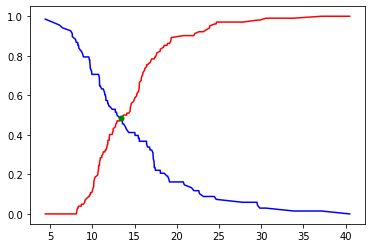

EER: 0.4852941176470588


In [270]:
#prediction based on segments individualy 
# selected_owners = ['mino']
# df_train, df_test = split_to_train_test_by_pattern_new(all_features, selected_owners)

# if not delete_nan_features:
#     df_train, df_test =  use_imputation(df_train, train_x_columns, df_test)
    
predicted = use_knn(df_train[train_x_columns],df_test[train_x_columns])


# test_y, predicted_y = unify_y_column_format(df_test[train_y_columns], tresholds, selected_owners,treshold_for_knn)
# show_results(test_y,predicted_y)

plot_far_eer(df_test[train_y_columns].reset_index(drop=True),predicted)

In [ ]:
#prediction based on patterns
# selected_owners = ['mino']
# df_train, df_test = split_to_train_test_by_pattern(all_features, selected_owners)

# if not delete_nan_features:
#     df_train, df_test =  use_imputation(df_train, train_x_columns, df_test)
    
predicted = use_knn(df_train[train_x_columns],df_test[train_x_columns])

df_results =  df_test[[train_y_columns,'id']]
df_results['prediction'] = predicted


nieco=df_results.groupby([train_y_columns,'id']).median()
nieco=nieco.reset_index().drop('id', axis=1)

# test_y, predicted_y = unify_y_column_format(nieco[train_y_columns], nieco['prediction'], selected_owners,treshold_for_knn)
# show_results(test_y,predicted_y)

plot_far_eer(nieco[train_y_columns],nieco['prediction'])


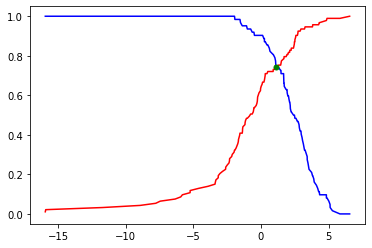

EER: 0.7419354838709677


In [178]:
predicted = use_svm(df_train[train_x_columns],df_test[train_x_columns])
plot_far_eer(df_test[train_y_columns], predicted)

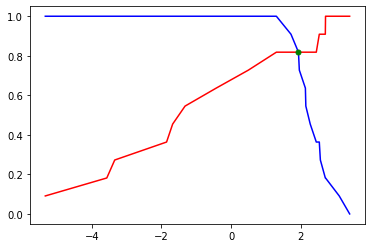

EER: 0.8181818181818182


In [179]:
predicted = use_svm(df_train[train_x_columns],df_test[train_x_columns])

df_results =  df_test[[train_y_columns,'id']]
df_results['prediction'] = predicted


nieco=df_results.groupby([train_y_columns,'id']).mean()
nieco=nieco.reset_index().drop('id', axis=1)

# test_y, predicted_y = unify_y_column_format(nieco[train_y_columns], nieco['prediction'], selected_owners,treshold_for_knn)
# show_results(test_y,predicted_y)

plot_far_eer(nieco[train_y_columns],nieco['prediction'])

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(df_train[train_x_columns], [1]*len(df_train[train_x_columns]))
y_pred = xgb_model.predict(df_test[train_x_columns])
test_converted = [1 if i in selected_owners else 0 for i in df_test[train_y_columns]]
print(confusion_matrix(test_converted, y_pred))
print(xgb_model.classes_)

In [ ]:
train_x_columns=selected_features_dict[125]
len(train_x_columns)

In [107]:
df_raw_train, df_raw_val, df_raw_test = split_to_train_val_test_raw(all_features)

if not delete_nan_features:
    df_raw_train, df_raw_val, df_raw_test =  use_imputation([df_raw_train, df_raw_val, df_raw_test], train_x_columns)
    
df_raw_train.to_csv(path_to_featutes + "imputed/" + "train.csv", encoding='utf-8', index=False)
df_raw_val.to_csv(path_to_featutes + "imputed/" + "val.csv", encoding='utf-8', index=False)
df_raw_test.to_csv(path_to_featutes + "imputed/" + "test.csv", encoding='utf-8', index=False)

In [113]:
selected_features_dict = {}
selected_features_dict[0]=train_x_columns

class RandomForestClassifierWithCoef(RandomForestClassifier):
    def fit(self, *args, **kwargs):
        super(RandomForestClassifierWithCoef, self).fit(*args, **kwargs)
        self.coef_ = self.feature_importances_
        
models = [LogisticRegression(solver='lbfgs'), RandomForestClassifierWithCoef(n_estimators=500, min_samples_leaf=5, n_jobs=-1)]

for number in [75,85,100,125,150]:
    print(number)
    for model in models:
        rfe = RFE(model, number)
#         rfe = RFECV(estimator=model, step=1, cv=2, scoring='roc_auc', verbose=2)
        fit = rfe.fit(df_raw_train[train_x_columns], df_raw_train[train_y_columns])

        # print("Num Features: %d" % fit.n_features_)
        # print("Selected Features: %s" % fit.support_)
        # print("Feature Ranking: %s" % fit.ranking_)
        indexes_to_delete=[]
        for i in range(len(fit.ranking_)):
            if(fit.ranking_[i]!=1):
                indexes_to_delete.append(i)
        selected_features = [i for j, i in enumerate(train_x_columns) if j not in indexes_to_delete]
        selected_features_dict[str(rfe)]=selected_features

for k in selected_features_dict.keys():
    new_key = ' '.join(str(k).replace("\\n", " ").split())
    selected_features_dict[new_key] = selected_features_dict.pop(k)
print(selected_features_dict)

75
85
100
125
150


In [ ]:
selected_owners = ['Martin']
df_train, df_val, df_test = adapt_dfs_to_users(df_raw_train, df_raw_val, df_raw_test, selected_owners)

In [225]:
test_eer_array=[]
val_eer_array=[]
predict_based_on_whole_pattern = True

for selected_owners in users_to_cv:
    df_train, df_val, df_test = adapt_dfs_to_users(df_raw_train, df_raw_val, df_raw_test, selected_owners)
    
    knn = get_knn()
    knn.fit(df_train[train_x_columns])
    
    predicted_val=[np.mean(i) for i in knn.kneighbors(df_val[train_x_columns])[0]]
    if predict_based_on_whole_pattern:

        df_results =  df_val[[train_y_columns,'id']]
        df_results['prediction'] = predicted_val
        nieco=df_results.groupby([train_y_columns,'id']).median()
        nieco=nieco.reset_index().drop('id', axis=1)
        
        ground_truth_val, predicted_val = nieco[train_y_columns], nieco['prediction']
    else:
        ground_truth_val= df_val[[train_y_columns]]
    
    val_eer_array.append(get_eer(ground_truth_val, predicted_val))
    
    
    predicted_test=[np.mean(i) for i in knn.kneighbors(df_test[train_x_columns])[0]]

    df_results =  df_test[[train_y_columns,'id']]
    df_results['prediction'] = predicted_test
    nieco=df_results.groupby([train_y_columns,'id']).median()
    nieco=nieco.reset_index().drop('id', axis=1)
    
    if predict_based_on_whole_pattern:
            ground_truth_test, predicted_test = nieco[train_y_columns], nieco['prediction']
    else:
        ground_truth_test= df_test[[train_y_columns]]

    test_eer_array.append(get_eer(ground_truth_test, predicted_test))
    
    
val_eer = mean(val_eer_array)
test_eer = mean(test_eer_array)

In [226]:
val_eer

0.4298354516163881

In [227]:
test_eer

0.3321656325836928

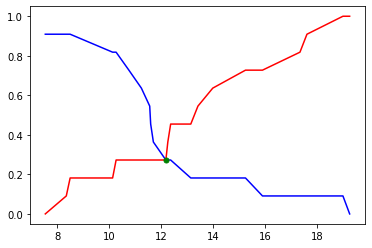

EER: 0.2727272727272727


In [291]:
predict_based_on_whole_pattern = True

selected_owners = 'Martin'
df_train, df_val, df_test = adapt_dfs_to_users(df_raw_train, df_raw_val, df_raw_test, selected_owners)

knn = get_knn()
knn.fit(df_train[train_x_columns])

predicted_test=[np.mean(i) for i in knn.kneighbors(df_test[train_x_columns])[0]]


if predict_based_on_whole_pattern == True:
    df_results =  df_test[[train_y_columns,'id']]
    df_results['prediction'] = predicted_test
    nieco=df_results.groupby([train_y_columns,'id']).median()
    nieco=nieco.reset_index().drop('id', axis=1)
    ground_truth_test, predicted_test = nieco[train_y_columns], nieco['prediction']
else:
    ground_truth_test = df_test[train_y_columns]
    

plot_far_eer(ground_truth_test, predicted_test)
